Import necessary Libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
from scipy.io import wavfile
import soundfile as sf
import tensorflow as tf
import tensorflow_hub as hub
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import scipy
import librosa
import pandas as pd
import os
from scipy.io import wavfile
from tqdm import tqdm
import random
from pydub import AudioSegment
import os
import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub


Visualise Class Distribution

In [56]:
# Define input folder containing the preprocessed audio files
input_folder = r'AudioSet\new_created'

# Initialize lists to store data
file_paths = []
class_names = []

# Iterate over each file in the input folder
for file_name in os.listdir(input_folder):
    folder_path = os.path.join(input_folder, file_name)
    
    # Check if the item is a directory
    if os.path.isdir(folder_path):
        class_name = file_name  # Use folder name as class name
        
        # Iterate over files in the directory
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                
                # Append file path and class name to lists
                file_paths.append(file_path)
                class_names.append(class_name)

# Create DataFrame from the collected data
preprocessed_df = pd.DataFrame({
    'filename': file_paths,
    'category': class_names
})

# Display DataFrame
print(preprocessed_df)

                                                filename        category
0      AudioSet\new_created\book_page_flip\a5-book-fl...  book_page_flip
1      AudioSet\new_created\book_page_flip\a5-book-fl...  book_page_flip
2      AudioSet\new_created\book_page_flip\a5-book-fl...  book_page_flip
3      AudioSet\new_created\book_page_flip\a5-book-fl...  book_page_flip
4      AudioSet\new_created\book_page_flip\a5-book-fl...  book_page_flip
...                                                  ...             ...
25012  AudioSet\new_created\Vacuum_cleaner\vacuum_cle...  Vacuum_cleaner
25013  AudioSet\new_created\Vacuum_cleaner\vacuum_cle...  Vacuum_cleaner
25014  AudioSet\new_created\Vacuum_cleaner\vacuum_cle...  Vacuum_cleaner
25015  AudioSet\new_created\Vacuum_cleaner\vacuum_cle...  Vacuum_cleaner
25016  AudioSet\new_created\Vacuum_cleaner\vacuum_cle...  Vacuum_cleaner

[25017 rows x 2 columns]


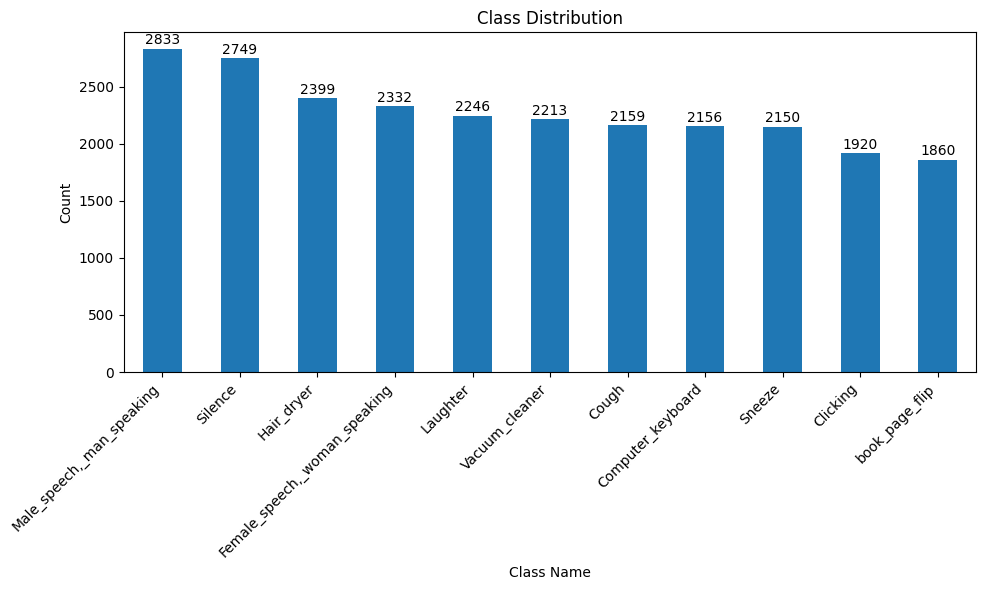

In [57]:
import matplotlib.pyplot as plt

# Group by class_name and count occurrences
class_distribution = preprocessed_df['category'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
ax = class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add count annotations to each bar
for i, count in enumerate(class_distribution):
    ax.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

Data Importing

In [58]:
data_path = r"AudioSet\new_created"

In [59]:
def ensure_sample_rate(original_sample_rate, waveform, desired_sample_rate=22000):
    if original_sample_rate != desired_sample_rate:
        desired_length = int(
            round(float(len(waveform))/original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return desired_sample_rate, waveform

In [60]:
def read_audio(filename):
    wav_data, sample_rate = sf.read(file=filename, dtype=np.int16)
    if len(wav_data.shape) > 1:
        wav_data = np.mean(wav_data, axis=1)
    sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)
    return sample_rate, wav_data

Process Data in Batches

In [61]:
import os
from tqdm import tqdm

batch_size = 1  # Set the batch size to control memory usage
max_samples_per_class = 300  # Maximum number of samples to collect for each class

audio_data = []


directories = os.listdir(data_path)


for class_name in tqdm(directories, desc="Processing classes"):
    class_path = os.path.join(data_path, class_name)
    if not os.path.isdir(class_path):
        continue

    samples_processed = 0

    for filename in tqdm(os.listdir(class_path), desc=f"Processing files in {class_name}"):
        if samples_processed >= max_samples_per_class:
            break

        file_path = os.path.join(class_path, filename)
        # Read and process audio file here
        audio_data.append([read_audio(file_path)[1], class_name])
        samples_processed += 1

Processing files in Cough:  14%|█▍        | 300/2159 [00:04<00:28, 65.18it/s]
Processing files in Female_speech,_woman_speaking:  13%|█▎        | 300/2332 [00:04<00:30, 66.01it/s]
Processing classes: 100%|██████████| 11/11 [00:51<00:00,  4.65s/it]


In [6]:
audio_dataframe = pd.DataFrame(audio_data, columns=["audio_data", "class"])
print(audio_dataframe.head())

                                          audio_data           class
0  [5.263631976533541, -3.139042898605985, 2.5308...  book_page_flip
1  [5.649386666410703, -3.377455392636766, 2.7216...  book_page_flip
2  [4.787491382005698, -2.860776663152237, 2.3036...  book_page_flip
3  [-145.42775343817215, 282.78827573836764, -123...  book_page_flip
4  [5.263631976533541, -3.139042898605985, 2.5308...  book_page_flip


Data Visualisation

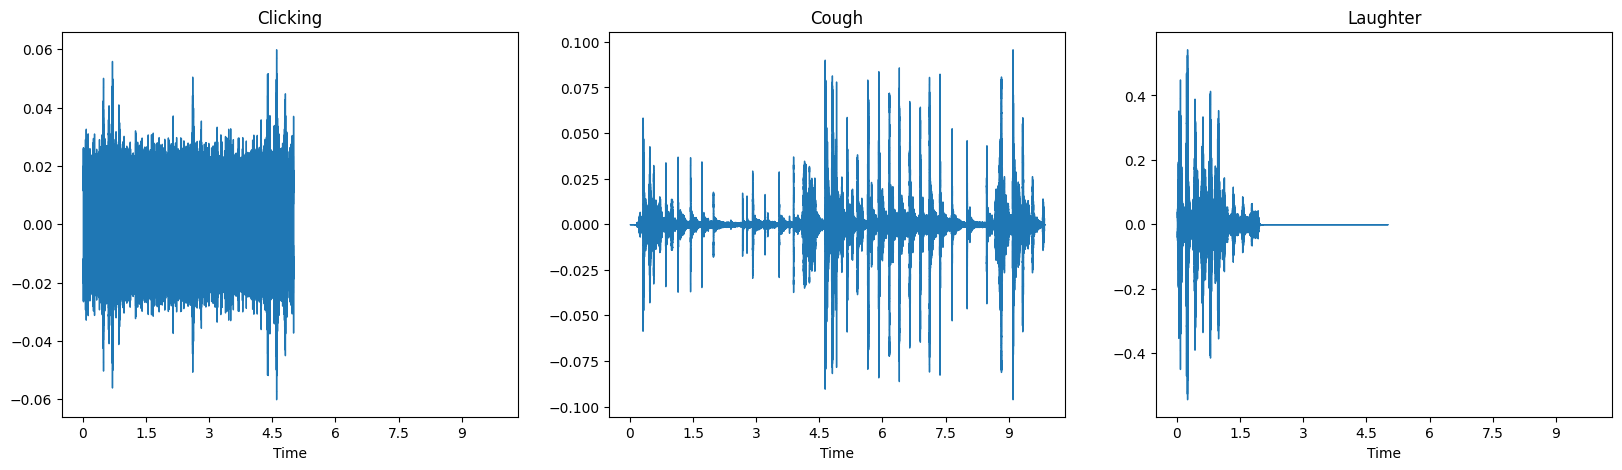

In [8]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

clicking_data, clicking_sr = librosa.load(r"AudioSet\new_created\Clicking\mouse_click_26_aug_comb_AddGaussianNoise_aug.wav")
cough_data, cough_sr = librosa.load(r"AudioSet\new_created\Cough\Cough_8_aug.wav")
laughter_data, laughter_sr = librosa.load(r"AudioSet\new_created\Laughter\laughing_68_aug_comb_PitchShift_Gain_aug.wav")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
librosa.display.waveshow(clicking_data, sr=clicking_sr, ax=ax1)
ax1.set_title("Clicking")

librosa.display.waveshow(cough_data, sr=cough_sr, ax=ax2)
ax2.set_title("Cough")

librosa.display.waveshow(laughter_data, sr=laughter_sr, ax=ax3)
ax3.set_title("Laughter")

plt.show()


In [9]:
wav_file_name = r'AudioSet\new_created\Laughter\laughing_68_aug_comb_PitchShift_Gain_aug.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, "rb")
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)
 
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')
 
Audio(wav_data, rate=sample_rate)

Sample rate: 22000 Hz
Total duration: 5.00s
Size of the input: 110000


In [10]:
audio_dataframe.head(10)

,audio_data,class
0,"[5.263631976533541, -3.139042898605985, 2.5308...",book_page_flip
1,"[5.649386666410703, -3.377455392636766, 2.7216...",book_page_flip
2,"[4.787491382005698, -2.860776663152237, 2.3036...",book_page_flip
3,"[-145.42775343817215, 282.78827573836764, -123...",book_page_flip
4,"[5.263631976533541, -3.139042898605985, 2.5308...",book_page_flip
5,"[5.263631976533541, -3.139042898605985, 2.5308...",book_page_flip
6,"[3.205017930870247, -1.9096697424397928, 1.536...",book_page_flip
7,"[-0.43009932940765283, 0.11984446539363319, -0...",book_page_flip
8,"[72.34555440528716, -25.680806304600594, 63.52...",book_page_flip
9,"[0.22068071490524646, -0.24843107052147675, -0...",book_page_flip


In [11]:
audio_data = np.array(audio_dataframe["audio_data"])

In [12]:
audio_data

array([array([  5.26363198,  -3.1390429 ,   2.53089968, ..., -27.81449101,
              -68.28098821,  40.30987772])                                ,
       array([  5.64938667,  -3.37745539,   2.7216556 , ..., -29.43611728,
              -71.92798892,  42.75749511])                                ,
       array([  4.78749138,  -2.86077666,   2.30366862, ..., -25.06591257,
              -61.66275519,  35.96914079])                                ,
       ...,
       array([2033.        , 2002.2023028 , 1520.84742864, ...,  110.81771435,
              -375.7444756 ,  641.81659984])                                  ,
       array([3453.        , 3400.46492472, 2582.61781298, ...,  189.97665631,
              -637.62552992, 1089.98241999])                                  ,
       array([3076.        , 3646.46470811, 2329.74150821, ...,  261.14658329,
              -275.98544599,  706.97858019])                                  ],
      dtype=object)

Google's Yamnet Model

In [13]:
model_yamnet = hub.load('https://tfhub.dev/google/yamnet/1')


Yamnet Embeddings for our audios

In [15]:
from tqdm import tqdm

audio_embeddings = []
for i in tqdm(audio_data, desc="Processing audio embeddings using Yamnet Model: "):
    waveform = i / tf.int16.max
    scores, embeddings, spectrogram = model_yamnet(waveform)
    audio_embeddings.append(embeddings)


Processing audio data: 100%|██████████| 3300/3300 [05:18<00:00, 10.35it/s]


In [16]:
padded_audio_embeddings = []
for i in audio_embeddings:
    padding_needed = tf.maximum(100 - i.shape[0], 0)
    padded_tensor = tf.pad(i, [[0, padding_needed], [0, 0]])
    padded_audio_embeddings.append(padded_tensor)

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max(len(seq) for seq in padded_audio_embeddings)
padded_audio_embeddings = pad_sequences(padded_audio_embeddings, maxlen=max_length, padding='post')

# Convert to NumPy array
padded_audio_embeddings = np.array(padded_audio_embeddings)


One-Hot Encoding for Labels

In [19]:
ohe = OneHotEncoder(sparse_output=False)
classes = ohe.fit_transform(audio_dataframe[["class"]])

In [20]:
# Get the class labels
class_labels = ohe.categories_[0]

# Print all class labels
for i, label in enumerate(class_labels):
    print(f"Class corresponding to {i}: {label}")


Class corresponding to 0: Clicking
Class corresponding to 1: Computer_keyboard
Class corresponding to 2: Cough
Class corresponding to 3: Female_speech,_woman_speaking
Class corresponding to 4: Hair_dryer
Class corresponding to 5: Laughter
Class corresponding to 6: Male_speech,_man_speaking
Class corresponding to 7: Silence
Class corresponding to 8: Sneeze
Class corresponding to 9: Vacuum_cleaner
Class corresponding to 10: book_page_flip


Data Splitting

In [21]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(padded_audio_embeddings, classes, random_state=42, test_size=0.1)

In [22]:
length_x_train = len(xtrain)
length_x_test = len(xtest)
length_y_train = len(ytrain)
length_y_test = len(ytest)

print("Length of x_train:", length_x_train)
print("Length of x_test:", length_x_test)
print("Length of y_train:", length_y_train)
print("Length of y_test:", length_y_test)

Length of x_train: 2970
Length of x_test: 330
Length of y_train: 2970
Length of y_test: 330


Fine Tuning

In [23]:
from tensorflow.keras import models, layers


num_classes = 11

input_shape = (169, 1024)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [25]:
history = model.fit(xtrain, ytrain, epochs=20, batch_size=32, validation_data=(xtest, ytest))

Epoch 1/20
93/93 [==============================] - 4s 38ms/step - loss: 0.2561 - accuracy: 0.9064 - val_loss: 0.2765 - val_accuracy: 0.9212
Epoch 2/20
93/93 [==============================] - 3s 31ms/step - loss: 0.2197 - accuracy: 0.9226 - val_loss: 0.2445 - val_accuracy: 0.9333
Epoch 3/20
93/93 [==============================] - 3s 29ms/step - loss: 0.2284 - accuracy: 0.9189 - val_loss: 0.2853 - val_accuracy: 0.9182
Epoch 4/20
93/93 [==============================] - 3s 28ms/step - loss: 0.2256 - accuracy: 0.9168 - val_loss: 0.2865 - val_accuracy: 0.9061
Epoch 5/20
93/93 [==============================] - 3s 28ms/step - loss: 0.2291 - accuracy: 0.9175 - val_loss: 0.2895 - val_accuracy: 0.9121
Epoch 6/20
93/93 [==============================] - 3s 28ms/step - loss: 0.2568 - accuracy: 0.9185 - val_loss: 0.3164 - val_accuracy: 0.9212
Epoch 7/20
93/93 [==============================] - 3s 29ms/step - loss: 0.1961 - accuracy: 0.9350 - val_loss: 0.2768 - val_accuracy: 0.9182
Epoch 8/20
93

Testing Accuracy

In [27]:
loss, accuracy = model.evaluate(xtest, ytest)
print("Loss: ",loss)
print("Accuracy: ", accuracy)

11/11 [==============================] - 0s 19ms/step - loss: 0.3228 - accuracy: 0.9273
Loss:  0.32280078530311584
Accuracy:  0.9272727370262146


Save Trained Model

In [28]:
model.save("YamNet_Transfer_Learning.h5")

Confusion Matrix

Confusion matrix, without normalization
Confusion matrix, without normalization


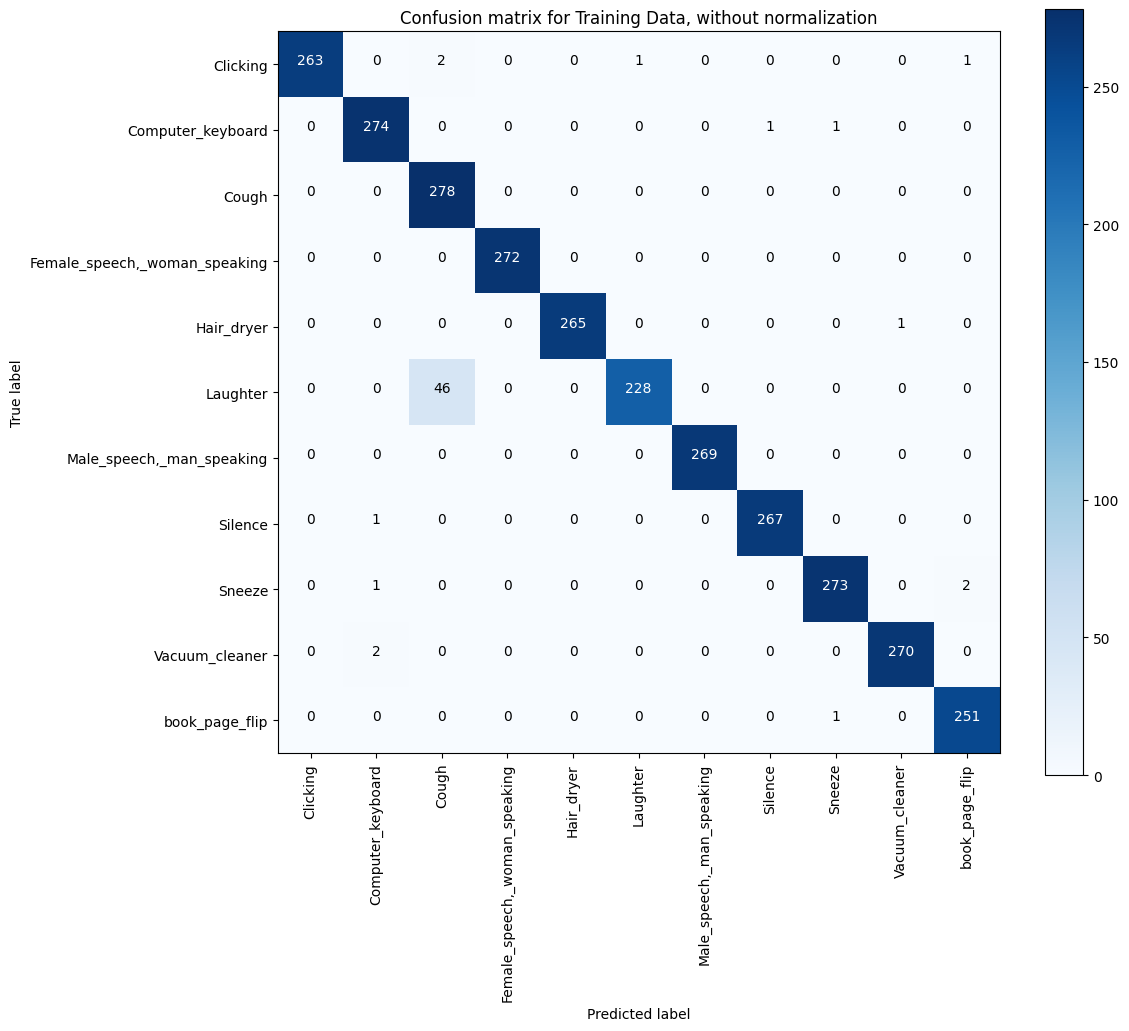

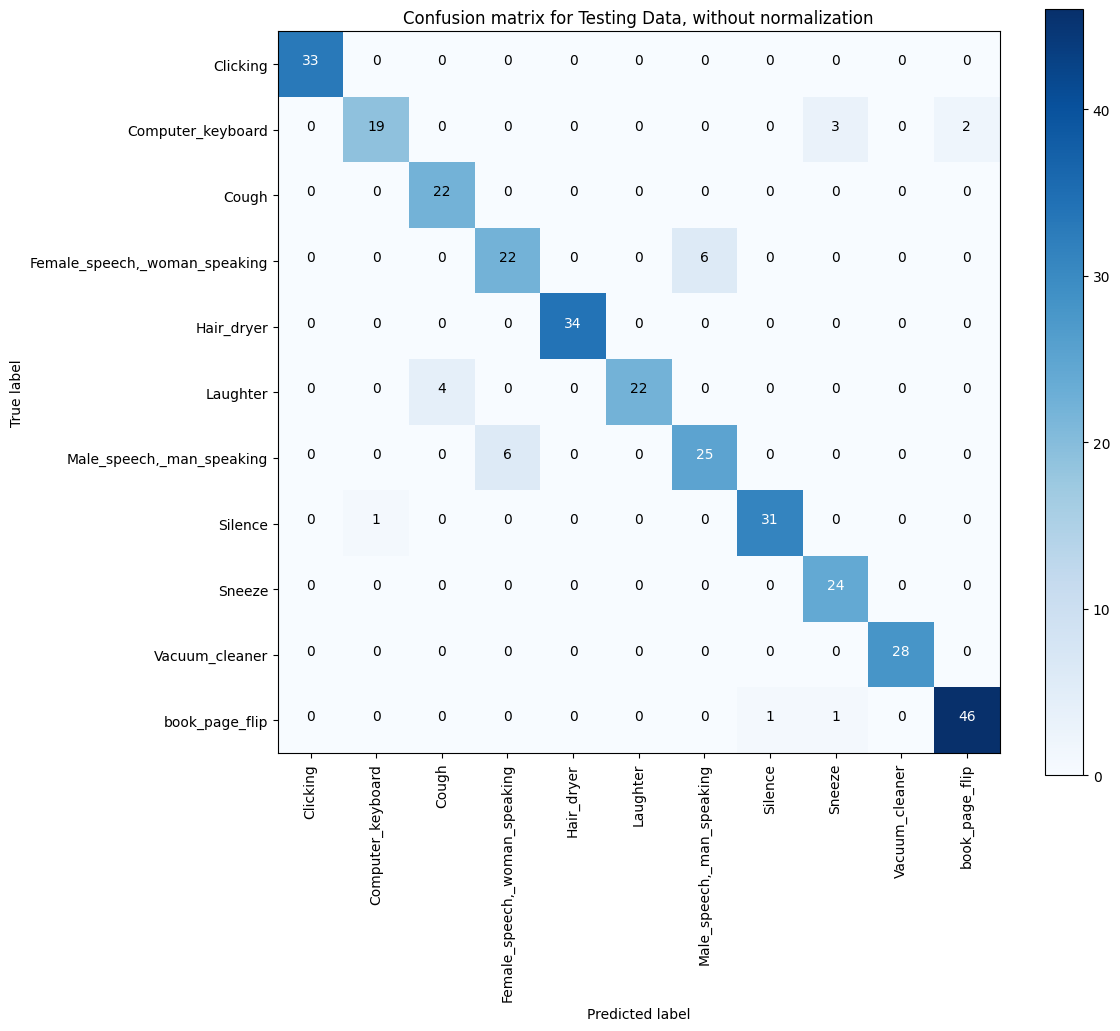

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

y_train_pred = model.predict(xtrain)
y_test_pred = model.predict(xtest)


y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

cm_train = confusion_matrix(np.argmax(ytrain, axis=1), y_train_pred_classes)
cm_test = confusion_matrix(np.argmax(ytest, axis=1), y_test_pred_classes)


class_names = {
    0: "Clicking",
    1: "Computer_keyboard",
    2: "Cough",
    3: "Female_speech,_woman_speaking",
    4: "Hair_dryer",
    5: "Laughter",
    6: "Male_speech,_man_speaking",
    7: "Silence",
    8: "Sneeze",
    9: "Vacuum_cleaner",
    10: "book_page_flip"
}

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [class_names[i] for i in classes], rotation=45)
    plt.yticks(tick_marks, [class_names[i] for i in classes])

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plt.figure(figsize=(12, 10))  
plot_confusion_matrix(cm_train, classes=np.unique(np.argmax(ytrain, axis=1)), title='Confusion matrix for Training Data, without normalization')

plt.xticks(rotation=90) 

plt.figure(figsize=(12, 10))  
plot_confusion_matrix(cm_test, classes=np.unique(np.argmax(ytest, axis=1)), title='Confusion matrix for Testing Data, without normalization')

plt.xticks(rotation=90)  

plt.show()



Testing for Trained Model

In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.io import wavfile

def pipeline(filename):
    audio_data = read_audio(filename)[1]
    audio_data = audio_data / np.iinfo(np.int16).max  # Normalize audio data
    scores, embeddings, spectrogram = model_yamnet(audio_data)
    
    # Pad or truncate embeddings to match the expected input shape
    if embeddings.shape[0] < 169:
        padding_needed = 169 - embeddings.shape[0]
        padded_embeddings = np.pad(embeddings, [(0, padding_needed), (0, 0)])
    else:
        padded_embeddings = embeddings[:169, :]
    
    # Reshape the padded tensor to match the input shape expected by the model
    padded_tensor = tf.reshape(padded_embeddings, (1, 169, 1024))
    
    # Get the probability distribution for the classes
    prob = model.predict(padded_tensor)[0]
    max_index = np.argmax(prob)
    
    # Define the class names corresponding to indices
    class_names = {
        0: "Clicking",
        1: "Computer_keyboard",
        2: "Cough",
        3: "Female_speech,_woman_speaking",
        4: "Hair_dryer",
        5: "Laughter",
        6: "Male_speech,_man_speaking",
        7: "Silence",
        8: "Sneeze",
        9: "Vacuum_cleaner",
        10: "book_page_flip"
    }
    
    # Return the corresponding class name
    return class_names[max_index]

# Example usage
print("The audio given is of:", pipeline(r"AudioSet\new_created\Male_speech,_man_speaking\868.wav"))


The audio given is of: Male_speech,_man_speaking
